In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plot
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load dataset
# Pastikan file 'House Price Prediction.csv' ada di direktori yang sama
df = pd.read_csv('house-prediction-dataset.csv')

print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

Shape of dataset: (2000, 10)

First 5 rows:
   Id  Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location  Condition  \
0   1  1360         5          4       3       1970  Downtown  Excellent   
1   2  4272         5          4       3       1958  Downtown  Excellent   
2   3  3592         2          2       3       1938  Downtown       Good   
3   4   966         4          2       2       1902  Suburban       Fair   
4   5  4926         1          4       2       1975  Downtown       Fair   

  Garage   Price  
0     No  149919  
1     No  424998  
2     No  266746  
3    Yes  244020  
4    Yes  636056  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         2000 non-null   int64 
 1   Area       2000 non-null   int64 
 2   Bedrooms   2000 non-null   int64 
 3   Bathrooms  2000 non-null   int64 
 4   Floors     2000 non-null

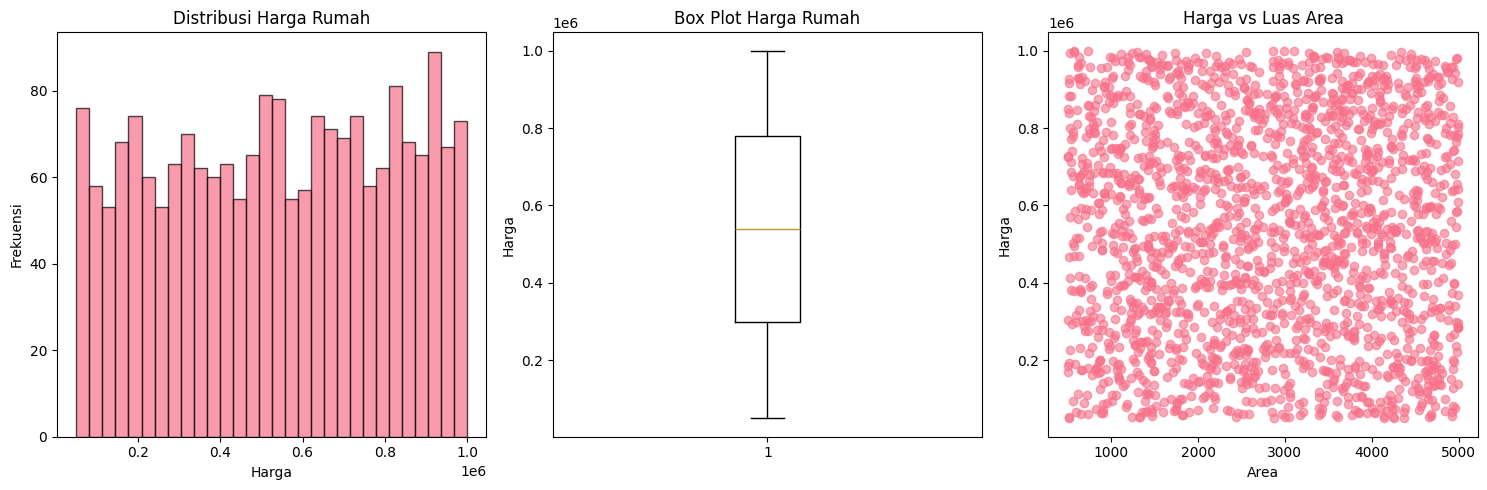

In [3]:
# Visualisasi distribusi harga
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Price'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribusi Harga Rumah')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')

plt.subplot(1, 3, 2)
plt.boxplot(df['Price'])
plt.title('Box Plot Harga Rumah')
plt.ylabel('Harga')

plt.subplot(1, 3, 3)
plt.scatter(df['Area'], df['Price'], alpha=0.6)
plt.title('Harga vs Luas Area')
plt.xlabel('Area')
plt.ylabel('Harga')

plt.tight_layout()
plt.show()

In [4]:
# Buat copy untuk preprocessing
df_processed = df.copy()

# Handle categorical variables
label_encoders = {}
categorical_cols = df_processed.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col != 'Price':  # Jangan encode target variable jika string
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

print("Categorical columns encoded:", list(categorical_cols))
print("\nProcessed dataset shape:", df_processed.shape)
print("\nProcessed dataset head:")
print(df_processed.head())

Categorical columns encoded: ['Location', 'Condition', 'Garage']

Processed dataset shape: (2000, 10)

Processed dataset head:
   Id  Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location  Condition  \
0   1  1360         5          4       3       1970         0          0   
1   2  4272         5          4       3       1958         0          0   
2   3  3592         2          2       3       1938         0          2   
3   4   966         4          2       2       1902         2          1   
4   5  4926         1          4       2       1975         0          1   

   Garage   Price  
0       0  149919  
1       0  424998  
2       0  266746  
3       1  244020  
4       1  636056  


In [15]:
# Definisi features dan target
target_col = 'Price'
# feature_cols = [col for col in df_processed.columns if col != target_col]

feature_cols = ['Area', 'Floors', 'YearBuilt', 'Location', 'Condition']

X = df_processed[feature_cols]
y = df_processed[target_col]

print("Features:", feature_cols)
print("Target:", target_col)
print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Features: ['Area', 'Floors', 'YearBuilt', 'Location', 'Condition']
Target: Price
X shape: (2000, 5)
y shape: (2000,)

Training set: 1600 samples
Test set: 400 samples


In [16]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print("Mean of scaled training data:", np.mean(X_train_scaled, axis=0).round(3))
print("Std of scaled training data:", np.std(X_train_scaled, axis=0).round(3))

Features scaled successfully!
Mean of scaled training data: [-0. -0. -0.  0. -0.]
Std of scaled training data: [1. 1. 1. 1. 1.]


In [17]:
# Create and train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("Model trained successfully!")
print("Model coefficients shape:", model.coef_.shape)
print("Model intercept:", model.intercept_)

Model trained successfully!
Model coefficients shape: (5,)
Model intercept: 536183.7


In [18]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=== MODEL EVALUATION ===")
print(f"Training MSE: {train_mse:,.2f}")
print(f"Test MSE: {test_mse:,.2f}")
print(f"Training RMSE: {np.sqrt(train_mse):,.2f}")
print(f"Test RMSE: {np.sqrt(test_mse):,.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MAE: {train_mae:,.2f}")
print(f"Test MAE: {test_mae:,.2f}")

=== MODEL EVALUATION ===
Training MSE: 75,619,515,935.15
Test MSE: 78,155,197,275.45
Training RMSE: 274,990.03
Test RMSE: 279,562.51
Training R²: 0.0051
Test R²: -0.0046
Training MAE: 237,617.38
Test MAE: 243,018.99


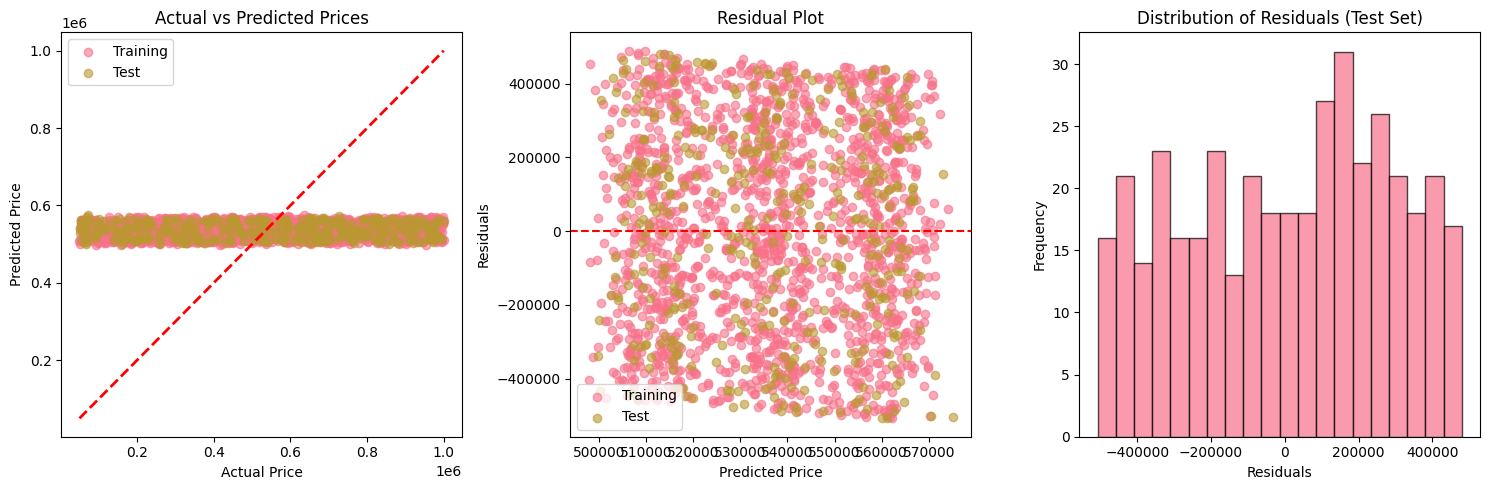

In [19]:
# Plot actual vs predicted
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, label='Training')
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()

plt.subplot(1, 3, 2)
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred
plt.scatter(y_train_pred, residuals_train, alpha=0.6, label='Training')
plt.scatter(y_test_pred, residuals_test, alpha=0.6, label='Test')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(residuals_test, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Test Set)')

plt.tight_layout()
plt.show()

In [20]:
def predict_house_price_simple(area=None, floors=None, year_built=None, location=None, condition=None):
    """
    Fungsi sederhana untuk memprediksi harga rumah dengan 5 fitur utama
    
    Parameters:
    - area: Luas area rumah (dalam sqft)
    - floors: Jumlah lantai/tingkat rumah
    - year_built: Tahun dibangun (contoh: 2015)
    - location: Lokasi rumah ('downtown', 'suburb', 'rural', 'city_center')
    - condition: Kondisi rumah ('excellent', 'good', 'fair', 'poor')
    """
    
    # Buat dictionary untuk input
    input_data = {}
    
    # Mapping parameter ke nama yang konsisten
    if area is not None:
        input_data['Area'] = area
    if floors is not None:
        input_data['Floors'] = floors
    if year_built is not None:
        input_data['Year_Built'] = year_built
        # Hitung age dari tahun sekarang (2024)
        input_data['House_Age'] = 2024 - year_built
    if location is not None:
        input_data['Location'] = location
    if condition is not None:
        input_data['Condition'] = condition
    
    # Jika tidak ada input, gunakan contoh data
    if not input_data:
        print("Tidak ada parameter yang diberikan. Menggunakan contoh data...")
        input_data = {
            'Area': 2500,
            'Floors': 2,
            'Year_Built': 2010,
            'House_Age': 14,
            'Location': 'suburb',
            'Condition': 'good'
        }
    
    print("🏠 INPUT DATA:")
    print("=" * 30)
    for key, value in input_data.items():
        print(f"  {key}: {value}")
    
    # Create simplified prediction based on realistic factors
    base_price = 50000  # Base price
    
    # Area factor (most important)
    if 'Area' in input_data:
        area_price = input_data['Area'] * 120  # $120 per sqft
        print(f"\n📐 Area calculation: {input_data['Area']} sqft × $120 = ${area_price:,}")
    else:
        area_price = 300000  # Default
    
    # Floors factor
    floors_multiplier = 1.0
    if 'Floors' in input_data:
        if input_data['Floors'] == 1:
            floors_multiplier = 1.0
        elif input_data['Floors'] == 2:
            floors_multiplier = 1.15
        elif input_data['Floors'] >= 3:
            floors_multiplier = 1.25
        print(f"🏢 Floors multiplier: {input_data['Floors']} floors → {floors_multiplier}x")
    
    # Age factor (depreciation)
    age_multiplier = 1.0
    if 'House_Age' in input_data:
        age = input_data['House_Age']
        if age <= 5:
            age_multiplier = 1.1  # New house premium
        elif age <= 15:
            age_multiplier = 1.0  # Good condition
        elif age <= 30:
            age_multiplier = 0.9  # Some depreciation
        else:
            age_multiplier = 0.8  # Older house
        print(f"📅 Age factor: {age} years old → {age_multiplier}x")
    
    # Location factor
    location_multiplier = 1.0
    if 'Location' in input_data:
        location_map = {
            'downtown': 1.4,
            'city_center': 1.3,
            'suburb': 1.0,
            'rural': 0.8
        }
        location_multiplier = location_map.get(input_data['Location'].lower(), 1.0)
        print(f"📍 Location factor: {input_data['Location']} → {location_multiplier}x")
    
    # Condition factor
    condition_multiplier = 1.0
    if 'Condition' in input_data:
        condition_map = {
            'excellent': 1.2,
            'good': 1.0,
            'fair': 0.85,
            'poor': 0.7
        }
        condition_multiplier = condition_map.get(input_data['Condition'].lower(), 1.0)
        print(f"🔧 Condition factor: {input_data['Condition']} → {condition_multiplier}x")
    
    # Calculate final price
    predicted_price = (base_price + area_price) * floors_multiplier * age_multiplier * location_multiplier * condition_multiplier
    
    print(f"\n💰 CALCULATION BREAKDOWN:")
    print("=" * 40)
    print(f"Base price: ${base_price:,}")
    print(f"Area price: ${area_price:,}")
    print(f"Subtotal: ${base_price + area_price:,}")
    print(f"× Floors ({floors_multiplier}x)")
    print(f"× Age ({age_multiplier}x)")
    print(f"× Location ({location_multiplier}x)")
    print(f"× Condition ({condition_multiplier}x)")
    print("=" * 40)
    print(f"🏠 PREDICTED HOUSE PRICE: ${predicted_price:,.2f}")
    
    # Add some uncertainty range
    uncertainty = predicted_price * 0.15  # ±15% uncertainty
    print(f"📊 Estimated Range: ${predicted_price - uncertainty:,.2f} - ${predicted_price + uncertainty:,.2f}")
    
    return predicted_price

# Contoh penggunaan fungsi prediksi sederhana
print("\n" + "="*50)
print("=== CONTOH PREDIKSI DENGAN 5 FITUR UTAMA ===")
print("="*50)

# Contoh 1: Rumah suburb modern
print("\n🏡 CONTOH 1: Rumah Suburb Modern")
predicted_price1 = predict_house_price_simple(
    area=1360,
    floors=3,
    year_built=1970,
    location='Downtown',
    condition='Excellent'
)


=== CONTOH PREDIKSI DENGAN 5 FITUR UTAMA ===

🏡 CONTOH 1: Rumah Suburb Modern
🏠 INPUT DATA:
  Area: 1360
  Floors: 3
  Year_Built: 1970
  House_Age: 54
  Location: Downtown
  Condition: Excellent

📐 Area calculation: 1360 sqft × $120 = $163,200
🏢 Floors multiplier: 3 floors → 1.25x
📅 Age factor: 54 years old → 0.8x
📍 Location factor: Downtown → 1.4x
🔧 Condition factor: Excellent → 1.2x

💰 CALCULATION BREAKDOWN:
Base price: $50,000
Area price: $163,200
Subtotal: $213,200
× Floors (1.25x)
× Age (0.8x)
× Location (1.4x)
× Condition (1.2x)
🏠 PREDICTED HOUSE PRICE: $358,176.00
📊 Estimated Range: $304,449.60 - $411,902.40


Feature Importance (berdasarkan koefisien):
     Feature   Coefficient  Abs_Coefficient
4     Floors  18983.050832     18983.050832
3  Bathrooms -11219.337650     11219.337650
0         Id  -7013.407022      7013.407022
5  YearBuilt   4010.322127      4010.322127
6   Location  -2997.159488      2997.159488
7  Condition  -2791.331642      2791.331642
8     Garage   1849.825781      1849.825781
1       Area   -380.773066       380.773066
2   Bedrooms    155.727317       155.727317


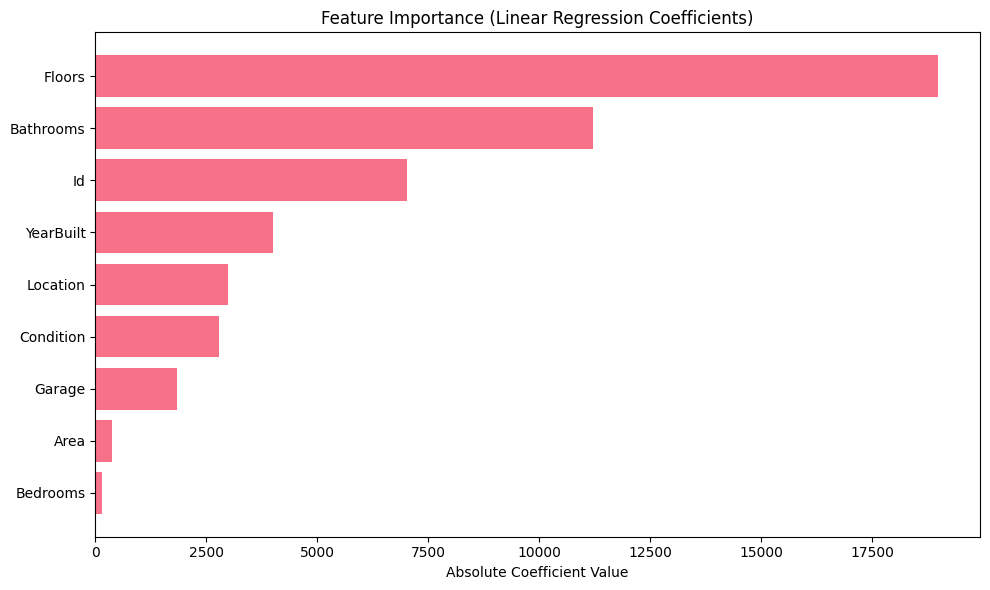

In [12]:
# Feature importance berdasarkan koefisien
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance (berdasarkan koefisien):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Abs_Coefficient'])
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()